# "Distributed Gradient Descent with Spark"
> "Optimization for big data."
- toc: true
- image: images/2020-03-15-distributed-gradient-descent/linreg.png
- branch: master
- badges: true
- comments: true
- categories: [data science]
- hide: false
- search_exclude: false

This post will walk through how to implement the batch gradient descent algorithm in a distributed fashion, using [PySpark](https://spark.apache.org/docs/latest/api/python/pyspark.html). There are many [variations of gradient descent](https://ruder.io/optimizing-gradient-descent/) out there, but this we will address "vanilla" gradient descent, and focus primarily on the implementational details in Spark.

Gradient descent is an optimization algorithm. Most typically, you'll see it associated with machine learning, which is the context we'll be working in, but it's important to acknowledge that it's fully able to stand up on it's own. The algorithm can equivalently be used to optimize a neural network or find the minimum of $f(x)=x^3-2x^2+2$. Generally speaking, the gradient descent algorithm tries to approximate what inputs correspond to the minimum value of a function. It makes no guarantees - meaning that the approximation may or may not be the true minimum. Mechanically, the algorithm exploits the property that the [gradient points in the direction of steepest ascent](https://math.stackexchange.com/questions/223252/why-is-gradient-the-direction-of-steepest-ascent). I will not be getting too deep into the weeds with the math, but if you're interested, here is a [high-level](https://hackernoon.com/life-is-gradient-descent-880c60ac1be8) and [low-level](https://mathworld.wolfram.com/MethodofSteepestDescent.html) overview.

# Gradient descent with NumPy

Before jumping directly into a distributed setting, it's helpful to start with a small example. First, we'll get our head around a vectorized implementation of gradient descent for linear regression, using NumPy.

Linear regression can be used to make predictions about a continuous target variable, using a set of predictor variables. We'll refer to those predictions as $\hat{y}$, where

$$\hat{y} = \underbrace{X}_{m\times n}\cdot \underbrace{w}_{n\times 1}$$

and $X$ is a matrix of $m$ observations, each observation composed of $n$ predictor variables. Additionally, $w$ is a vector of $n$ _weights_ (aka coefficients). Since our focus in on the algorithm, we'll use [`sklearn.datasets.make_regression()`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_regression.html) to generate a dataset, $X$, that is amenable to linear regression.

In [1]:
#collapse
import numpy as np
import matplotlib
matplotlib.rcParams['text.usetex'] = True
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression
from sklearn.metrics import r2_score
import time

In [2]:
data_kwargs = {"n_samples":100, "n_features":2,
               "noise":3, "coef":True, 
               "random_state":742}
X, y, coef = make_regression(**data_kwargs)
w = np.zeros(X.shape[1]).reshape(-1,1)
print(f"X is of type: {type(X)}, and of dimension: {X.shape}.")
print(f"w is of type: {type(w)}, and of dimension: {w.shape}.")
print(f"y is of type: {type(y)}, and of dimension: {y.reshape(-1,1).shape}.")

X is of type: <class 'numpy.ndarray'>, and of dimension: (100, 2).
w is of type: <class 'numpy.ndarray'>, and of dimension: (2, 1).
y is of type: <class 'numpy.ndarray'>, and of dimension: (100, 1).


{% include info.html text="Note: linear regression often has an intercept term in addition to the weights. We choost to omit it in this post." %}

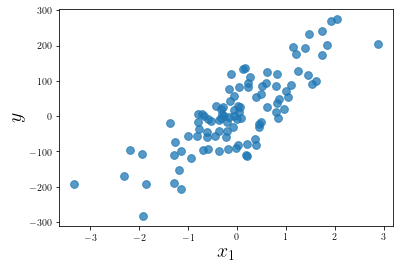

In [3]:
#collapse
plt.scatter(X[:, 0], y, alpha=0.75, s=60)
plt.xlabel(r"$x_1$", size=20)
plt.ylabel(r"$y$", size=20)
plt.show()

For our case, it's safe to instantiate $w$ with zeros. In machine learning, gradient descent iteratively updates the weights to minimize some loss function. The loss function's job is to tell us _how wrong_ our weights are at any given step of the algorithm. For linear regression, our loss function is the mean squared error of our predictions, $\hat{y}$, and the target variable, $y$.

$$
\begin{aligned}
MSE(y, \hat{y}) &= \frac{1}{m}\left(y - \hat{y}\right)^2\\
&= \frac{1}{m}\left(y - X\cdot w\right)^2
\end{aligned}
$$


The vectorized gradient of MSE is (for a full derivation, see [this stack exchange](https://math.stackexchange.com/questions/2887916/cost-function-vectorized-implementation)),

$$\frac{\partial\ \text{MSE}}{\partial\ w} = -\left(\frac{2}{m}\right)X^T\cdot \left(y - X\cdot w\right)$$


*You should note: in the equations about, we are doing element-wise subtraction between vectors $y$ and $\hat{y}$, as well as a dot product between a $X$ and $w$.*

In code, the MSE and its gradient can be implemented like this,

In [4]:
def mse(X, y, w):
    return ((y - np.dot(X, w))**2).mean()

def mse_gradient(X, y, w):
    residual = y - np.dot(X, w)
    return (-2/X.shape[0]) * np.dot(X.T, residual)

At this point, we have all the pieces we need to put the gradient descent algorithm to use in finding the optimal $w$. In our implementation, we will make `n_iters` updates to `w`, each time re-assigning it with the following rule, 

$$w \leftarrow w - \alpha \ \left(\frac{\partial\ \text{MSE}}{\partial\ w}\right)$$

where $\alpha$ is a small constant referred to as the [learning rate](https://heartbeat.fritz.ai/introduction-to-learning-rates-in-machine-learning-6ed685c16506).

In [5]:
# leaning towards verbosity to make code as clear as possible
def gradient_descent(X, y, learning_rate=0.1, n_iters=100):
    w = np.zeros(X.shape[1])
    for i in range(n_iters):
        w_gradient = mse_gradient(X, y, w)
        w = w - learning_rate*w_gradient
    
    return w

There are a couple ways to verify that our algorithm is working correctly. The simplest way is to plot our predictions against the raw data.

In [6]:
# change `n_features` for illustrative example
data_kwargs.update({"n_features":1})
X, y, coef = make_regression(**data_kwargs)
w = gradient_descent(X, y)

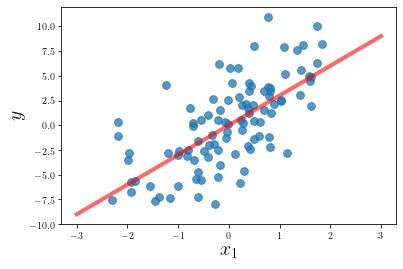

Our gradient descent converged on w = 3.0048.
Scikit-Learn used w = 3.0549 to generate the data.


In [9]:
#collapse
plt.scatter(X[:, 0], y, alpha=0.75, s=60)
xx = np.linspace(-3, 3, 100).reshape(-1, 1)
yy = np.dot(xx, w)
plt.plot(xx, yy, c='r', lw=4, alpha=0.6)
plt.xlabel(r"$x_1$", size=20)
plt.ylabel(r"$y$", size=20)
plt.show()
# plt.savefig("../images/2020-03-15-distributed-gradient-descent/linreg.png")

print(f"Our gradient descent converged on w = {round(w.item(), 4)}.")
print(f"Scikit-Learn used w = {round(coef.item(), 4)} to generate the data.")

It can be a bit trickier to visualize our predictions with multi-dimensional data, so we'll resort to evaluating $R^2$ scores, plotting the losses, and directly comparing the weights to Scikit-Learn's.

---

# Distributed gradient descent with PySpark

*Many of the ideas presented here come from [this lecture](https://stanford.edu/~rezab/classes/cme323/S17/notes/lecture16/cme323_lec16.pdf), given in the Spring of 2017 by Reza Zadeh, from Stanford.*

A single CPU is enough to crunch all of the matrix computation in the simple example above, but in the real-world setting, it is not uncommon to deal with datasets that are quite a few orders of magnitude larger. In these scenarios, it becomes advantageous to use multiple computers, in unison, to carry out our computations. For this, Spark is the perfect tool. While Spark's [MLlib](https://spark.apache.org/mllib/) has many off-the self algorithms, implementing our own gradient descent is a fantastic exercise to broaden our understanding of Spark and distributed computing.

In [57]:
import pyspark
sc = pyspark.SparkContext().getOrCreate()

Let's simulate some big(ger) data by bumping up `n_samples` to 1 million and `n_features` to 10.

In [58]:
data_kwargs.update({"n_samples":1_000_000, "n_features":10})
X, y, coef = make_regression(**data_kwargs)
data = np.hstack([X, y.reshape(-1,1)]).tolist()
rdd = sc.parallelize(data).cache()
print(f"Our RDD has {rdd.getNumPartitions()} partitions.")

Our RDD has 12 partitions.


Above, we've converted our dataset from a NumPy array to a Spark [resilient, distributed dataset (RDD)](https://spark.apache.org/docs/latest/rdd-programming-guide.html). It should be noted that we've used `np.hstack()` to combine our target, $y$, with our data, $X$. We'll have to remember that the last value in each row of the RDD is the target. This RDD splits up our dataset row by row and distributes those rows across each of our 12 partitions. Since our rows are not all collected in one place, we no longer have the ability to vectorize the computation across the entire dataset - instead we'll employ for loops to make aggregations in parallel on each partition. When calculating the gradients, we must do so *row by row*. Our approach will be to map each row of the RDD to its corresponding gradient, with respect to the weights. After this transformation, each row should maintain its dimension.

In [59]:
def distributed_mse_gradient(rdd_row, w):
    x = rdd_row[:-1]
    y = rdd_row[-1]
    residual = y - sum(x_j*w_j for x_j, w_j in zip(x, w)) # dot product
    weights_gradient = [-x_j*residual for x_j in x]
    return weights_gradient

The line that computes `residual` looks starkly different than it did in the original `mse_gradient()` function. It uses a nested `sum()` and generator comprehension to compute the dot product between $x$ and $w$.

$$\underbrace{x\cdot w}_{\text{dot product}} = \sum_{j=1}^{n}x_j\cdot w_j$$

Another distinction is that we've dropped the constant, $2$, on the front of the gradient. Since it is a constant, it will only impact the magnitude and not the direction of the gradient, which is what it is of interest to us.

Moreover, batch gradient descent requires us to use the average of all gradients across the entire dataset. This means that we have to implement some functionality to combine the gradients in each partition, then combine the aggregated gradients across all partitions. In Spark's vernacular, we need to *reduce* the RDD to a single row. We'll start by taking a cumulative sum of all gradients, then dividing by the number of rows in the RDD, $m$, later.

In [60]:
# cumulative sum of gradients
def cum_sum_gradients(row, next_row):
    return [gradient+next_gradient for gradient, next_gradient in zip(row, next_row)]

We these two helper functions, we can construct our distributed gradient descent loop.

In [61]:
# again, verbosity for clarity
def distributed_gradient_descent(rdd, learning_rate=0.1, n_iters=100):
    w = np.zeros(len(rdd.first())-1).tolist() # -1 because the last value is y
    m = rdd.count()
    for i in range(n_iters):
        rdd_gradient = rdd.map(lambda row: distributed_mse_gradient(row, w))\
                          .reduce(lambda row, next_row: cum_sum_gradients(row, next_row))
        
        # scaling with m and learning rate
        w_gradient = [learning_rate*(w/m) for w in rdd_gradient]
        
        # updating weights
        w = [w_j - w_grad_j for w_j, w_grad_j in zip(w, w_gradient)]
        
    return w

Let's take a moment to understand which lines are [transformations](https://spark.apache.org/docs/latest/rdd-programming-guide.html#transformations) and which are [actions](https://spark.apache.org/docs/latest/rdd-programming-guide.html#actions). In order to set things up, we must instantiate $w$ and $m$, which require `rdd.first()` and `rdd.count()`, respectively. These are both *actions*, meaning they kick off the Spark driver and run the code immediately. After we enter the loop, we map each row of the RDD to its corresponding gradient with `rdd.map()`. In Spark, mapping is *lazy evaluated*, meaning that when this line hits the interpreter, *nothing happens.* Well, that's not entirely true, however, what you'd expect does not necessarily happen. Instead of carrying out any mapping, Spark just adds the transformation to the RDD's [lineage](https://mallikarjuna_g.gitbooks.io/spark/spark-rdd-lineage.html), making a plan for the computation without executing it. It is not until the `.reduce()` (which is an action) line gets run, that Spark begins executing on the RDD and subsequently maps, then reduces it. This mapping and reducing yields us the gradient of our mean-squared loss function, which we use to update $w$ `n_iters` times.

In [62]:
w = distributed_gradient_descent(rdd, n_iters=50)

In [63]:
#collapse
w = [round(w_j, 2) for w_j in w]
coef = [round(c, 2) for c in coef]
print(f"""Here is a side-by-side comparison of our coefficients with Scikit-Learn's:
distributed gradient descent -> {w}
Scikit-Learn's coefficients  -> {coef}""")

Here is a side-by-side comparison of our coefficients with Scikit-Learn's:
distributed gradient descent -> [21.07, 29.56, 15.26, 19.46, 0.9, 74.74, 18.99, 94.1, 49.16, 79.15]
Scikit-Learn's coefficients  -> [21.18, 29.71, 15.33, 19.56, 0.91, 75.13, 19.09, 94.59, 49.41, 79.57]


Looks good!

## Saving time and space with broadcasting

There is one subtlety in our distributed gradient descent implementation that can be further optimized. When we map each row to its gradient, we must also pass it `w` each time, as it needs it for the computation. By default, Spark makes a copy of `w` and sends it to each of the 12 partitions. If each partition were going to be making changes to the weights, this would be necessary, however, they are not! In fact, each partition could make the gradient computations with *read-only* access to `w`. As a result, we are wasting space by storing a copy of `w` on each partition, and wasting time by sending it to each partition on each iteration.

Spark's solution is to use a [broadcast variable](https://spark.apache.org/docs/latest/rdd-programming-guide.html#broadcast-variables), which instead sends a single copy of `w` to each partition. We can add broadcasting to our `distributed_gradient_descent()` function with two extra lines.

In [64]:
# enhanced with broadcasting
def distributed_gradient_descent(rdd, learning_rate=0.1, n_iters=100):
    w = np.zeros(len(rdd.first())-1).tolist()
    w = sc.broadcast(w)       # broadcasting w
    m = rdd.count()
    for i in range(n_iters):
        rdd_gradient = rdd.map(lambda row: distributed_mse_gradient(row, w.value))\
                          .reduce(lambda row, next_row: cum_sum_gradients(row, next_row))
        w_gradient = [learning_rate*(w/m) for w in rdd_gradient]
        w = [w_j - w_grad_j for w_j, w_grad_j in zip(w.value, w_gradient)]
        w = sc.broadcast(w)    # re-broadcasting w on each iter
    return w

After broadcasting `w`, we have to call `w.value` to access the underlying weights.

In [65]:
w = distributed_gradient_descent(rdd, n_iters=50)

In [66]:
# shutting down spark context
sc.stop()

If you run this notebook locally, the distributed implementation almost certainly won't beat NumPy. The reason for this is that NumPy automatically makes use of all processors, and the overhead involved in setting up a Spark job. As Brandon Rohrer said, "It's tough to beat NumPy".

> twitter: https://twitter.com/_brohrer_/status/1226496604473090049

Spark truly shines when it's used to coordinate jobs across multiple machines. An interesting next step would be to spin up a cluster on [AWS EMR](https://aws.amazon.com/emr/) and increase `n_samples` to observe how well Spark is able to scale.